# General Adversarial Network (GAN) 

## Introduction

This notebook uses the [MNIST](https://archive.ics.uci.edu/dataset/683/mnist+database+of+handwritten+digits) dataset to train a general adversarial network (GAN) to perform generation of handwritten digits.

## Setup

### Global Parameters

These parameters...

In [1]:
BATCH_SIZE = 64
DATA_PATH = '../../datasets'
SEED = 1

### PyTorch Setup

In [2]:
import torch
from torch import nn, optim, Tensor
from torch.backends import cudnn

CUDA = torch.cuda.is_available()
print("PyTorch version: {}".format(torch.__version__))
if CUDA:
    print("CUDA version: {}\n".format(torch.version.cuda))
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda:0" if CUDA else "cpu")
cudnn.benchmark = True

PyTorch version: 2.2.0


## Dataset

The dataset is publicly available on the UC Irvine Repository.

### Importing data and pre-processing

Fortunately, PyTorch comes with several modules that help with handling data downloading and preprocessing.

In [3]:
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

data = datasets.MNIST(
    root=DATA_PATH,                          # the path to where the dataset is stored
    download=True,                           # download and cache the dataset locally
    transform=transforms.Compose([
        # transforms.Resize(64),               # resize the images from 28x28 to 64x64
        transforms.ToTensor(),               # convert a PIL image to PyTorch's Tensor
        # transforms.Normalize((0.5,), (0.5,)) # normalise the tensor to the range of 0 to 1
    ])
)

dataloader = DataLoader(
    data, 
    batch_size=BATCH_SIZE,                   # the number of samples to be used per batch
    shuffle=True,                            # shuffles the data randomly every epoch
    num_workers=2                            # use multiple subprocesses to speed up loading
)

### Exploratory Data Analysis (EDA)

We do some preliminary checks to get a sense of what we are working with.

In [4]:
print(f'Train data shape: {data.data.shape}')
print(f'Target shape: {data.targets.shape}')
print(f'Minimum value: {data.data[0].min()}')
print(f'Maximum value: {data.data[0].max()}')

# These are the possible classes of a handwritten digit
data.classes

Train data shape: torch.Size([60000, 28, 28])
Target shape: torch.Size([60000])
Minimum value: 0
Maximum value: 255


['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [5]:
# Examine a sample batch from the dataloader
real_batch = next(iter(dataloader)) # get an actual training data batch
print(real_batch[0].shape)
print(real_batch[1].shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


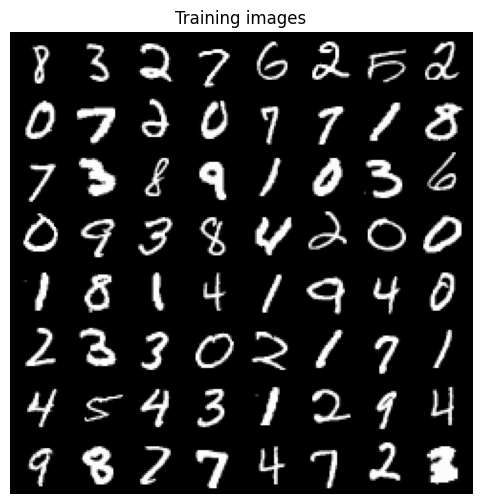

In [6]:
from typing import Union, Literal, Optional
from matplotlib import pyplot as plt
import pickle as pkl
import numpy as np

# A helper function to display images stored as a Tensor 
def display_images(images: Tensor, title: Optional[str] = None, figsize=(12, 4)):
    plt.figure(figsize=figsize)
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.imshow(
        np.transpose(
            utils.make_grid(                    # make a visual grid of images
                images.to(device)[:64], 
                normalize=True                  # normalise the images to the range (0, 1)
            ).cpu(),
            (1, 2, 0)
        )
    )

display_images(real_batch[0], title="Training images", figsize=(12, 6))

### Network Setup

To construct a GAN we need two networks, the **discriminator** and the **generator**. They form the basis of an "adversarial" network where one generates a data sample and the other discriminate whether this generated data is fake or not.

#### Discriminator

Notice that there are not any code written for backpropagation and this is the beauty of PyTorch where it uses `torch.autograd` to perform automatic differentiation to calculate the derivatives of what we specified in the `forward()` method. There is a good article [here](https://pytorch.org/tutorials/beginner/introyt/autogradyt_tutorial.html#autograd-in-training) introducing how it works behind the scenes.

In [7]:
class Discriminator(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Down sample the input to produce a binary output
        self.fc1 = nn.Linear(in_features=in_features, out_features=128)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.2)
        self.fc3 = nn.Linear(in_features=64, out_features=32)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.2)
        self.fc4 = nn.Linear(in_features=32, out_features=out_features)
        self.dropout = nn.Dropout(0.3)


    def forward(self, x):
        # Reshape image batch
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        # Feed forward
        x = self.fc1(x)
        x = self.leaky_relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.leaky_relu2(x)
        x = self.dropout(x)                        
        x = self.fc3(x)
        x = self.leaky_relu3(x)        
        x = self.dropout(x)
        logit_out = self.fc4(x)
        
        return logit_out


#### Generator

a

In [8]:
class Generator(nn.Module):
    def __init__(self, in_features, out_features):
        super(Generator, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Up sample the input to produce input of size suitable to feed into the discriminator
        self.fc1 = nn.Linear(in_features=in_features, out_features=32)
        self.relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.fc2 = nn.Linear(in_features=32, out_features=64)
        self.relu2 = nn.LeakyReLU(negative_slope=0.2)        
        self.fc3 = nn.Linear(in_features=64, out_features=128)
        self.relu3 = nn.LeakyReLU(negative_slope=0.2)        
        self.fc4 = nn.Linear(in_features=128, out_features=out_features)
        self.dropout = nn.Dropout(0.3)
        self.tanh = nn.Tanh()

    
    def forward(self, x):
        # Feed forward
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)        
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu3(x)        
        x = self.dropout(x)
        x = self.fc4(x)
        tanh_out = self.tanh(x)
        
        return tanh_out

#### Defining the loss function

These loss function is a measure between how far away the real / fake predicted output is to the target output.

In [9]:
class Loss:
    """
    A wrapper class for computing real / fake losses using the same underlying loss function
    """

    def __init__(self, loss: nn.Module, device: Union[Literal["cuda"], Literal["cpu"]]):
        self.loss = loss
        self.device = device

    def real(self, outputs: Tensor) -> Tensor:
        return self._loss(outputs, type="real")

    def fake(self, outputs: Tensor) -> Tensor:
        return self._loss(outputs, type="fake")

    def _loss(self, outputs: Tensor, type: Union[Literal["real"], Literal["fake"]]) -> Tensor:
        batch_size = outputs.shape[0]

        if type == "real":
            # The target is 1 because we expect it to be a real data from the dataset which is true
            targets = torch.ones(batch_size).to(self.device)
        elif type == "fake":
            # The target is 0 because we expect it to be a fake data that is not from the dataset
            targets = torch.zeros(batch_size).to(self.device)
        else:
            raise Exception(f"Unrecognised type: {type}, only 'real' or 'fake' is valid")

        return self.loss(outputs.squeeze(), targets)

#### Training the network

Both of the discriminator and generator networks will be trained together so one enhances the other.

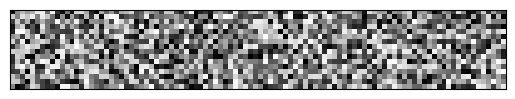

In [10]:
z_size = 100
z = np.random.uniform(-1, 1, size=(16, z_size))
plt.imshow(z, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [11]:
class Trainer:
    """
    A helper class to train General Adversarial Networks (GANs) which consists of 
    two networks namely the discriminator and the generator competing against each 
    other in a zero-sum game with the goal of achieving predictions close to the targets.
    """

    def __init__(
        self,
        discriminator: tuple[Discriminator, optim.Optimizer], 
        generator: tuple[Generator, optim.Optimizer],
        loss: Loss,
        dataloader: DataLoader,
        filepath: Optional[str],
        verbose: bool = False
    ):
        self.discriminator = discriminator[0]
        self.discriminator_optim = discriminator[1]
        self.generator = generator[0]
        self.generator_optim = generator[1]
        self.loss = loss
        self.dataloader = dataloader
        self.filepath = filepath
        self.verbose = verbose

    def _log(self, *values: object):
        if self.verbose:
            print(values[0], *values)

    def _gen_latent_vector(self, size: tuple[int, int]) -> Tensor:
        return torch.from_numpy(np.random.uniform(-1, 1, size=size))

    def train(
        self,
        epochs: int,
        device: Union[Literal["cuda"], Literal["cpu"]],
    ) -> tuple[list[float], list[float]]:
        self._log(f"Training on {device}...")

        # Generate a batch (say 16) of latent image vector (z) of fixed size 
        # (say 100 pixels) to be as input to the Generator after each epoch of 
        # training to generate a fake image. We'll visualise these fake images
        # to get a sense how generator improves as training progresses
        z_size = 100
        fixed_z = self._gen_latent_vector(size=(16, z_size)).float().to(device)
        fixed_samples = []
        d_losses, g_losses  = [], []
        d_optim, g_optim = self.discriminator_optim, self.generator_optim
        
        # Move discriminator and generator to available device
        d = self.discriminator.to(device)
        g = self.generator.to(device)

        for epoch in range(epochs):
            self._log(f'Epoch [{epoch + 1} / {epochs}]:')

            # Turn on training mode
            d.train()
            g.train()

            d_running_batch_loss = 0
            g_running_batch_loss = 0

            for curr_batch, (real_images, _) in enumerate(self.dataloader):
                real_images: Tensor = real_images.to(device) # move input batch to available devices

                # --------------------------------------------------------------------
                # Train discriminator using real images followed by fake images,     |
                # then compute the total loss and backpropagate through the network. |
                # --------------------------------------------------------------------

                d_optim.zero_grad() # reset the gradients

                # Real MNIST images
                real_images = (real_images * 2) - 1 # scale images to [-1, 1] 
                d_real_logits_out = d(real_images)
                d_real_loss = self.loss.real(d_real_logits_out)

                # Fake images
                with torch.no_grad():
                    z = self._gen_latent_vector(size=(self.dataloader.batch_size, z_size)).float().to(device)
                    fake_images = g(z)             # run the generator to get fake images

                d_fake_logits_out = d(fake_images) # feed fake images into the discriminator and compute the fake loss
                d_fake_loss = self.loss.fake(d_fake_logits_out)

                d_loss = d_real_loss + d_fake_loss # total discriminator loss

                d_loss.backward()                  # backpropagate discriminator 
                d_optim.step()                     # optimise (update parameters)

                d_running_batch_loss += d_loss     # accumulate the loss

                # -------------------------------------------------------------------
                # Train generator and compute the loss which is a metric that tells |
                # how successful the generator is in tricking the discriminator and |
                # backpropagate through the network.                                |
                # -------------------------------------------------------------------

                g_optim.zero_grad() # reset the gradients
                    
                z = self._gen_latent_vector(size=(self.dataloader.batch_size, z_size)).float().to(device)

                # Generate a batch of fake images, feed them to discriminator
                # and compute the generator loss as real_loss 
                # (i.e. target label = 1)
                fake_images = g(z) 
                g_logits_out = d(fake_images)
                g_loss = self.loss.real(g_logits_out)

                g_loss.backward()                  # backpropagate generator 
                g_optim.step()                     # optimise (update parameters)
                                                   
                g_running_batch_loss += g_loss     # accumulate the loss

                if curr_batch % 400 == 0:
                    self._log(f"\tBatch {curr_batch :> 4} / {len(self.dataloader) :> 4} - d_batch_loss: {d_loss.item():.6f}, g_batch_loss: {g_loss.item():.6f}")

            # Compute losses for the current epoch (block average)
            d_epoch_loss = d_running_batch_loss.item() / len(self.dataloader)
            g_epoch_loss = g_running_batch_loss.item() / len(self.dataloader)
            d_losses.append(d_epoch_loss)
            g_losses.append(g_epoch_loss)

            self._log(f"epoch_d_loss: {d_epoch_loss:.6f}, epoch_g_loss: {g_epoch_loss:.6f}\n")

            # Generate fake images from fixed latent vectors using trained generator thus far
            # and save them to a list
            g.eval()
            fixed_samples.append(g(fixed_z).detach().cpu())

        # Save previously generated images
        if self.filepath:
            with open(self.filepath, "wb") as f:
                pkl.dump(fixed_samples, f)
                self._log(f"saved fake images to {self.filepath}")

        return d_losses, g_losses


In [12]:
# Putting everything together and start training

EPOCHS = 100
LEARNING_RATE = 0.002
FAKE_IMAGES_FILE = "mnist_gan_fake_images.pkl"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

discriminator = Discriminator(in_features=784, out_features=1)   # 784 inputs and 1 output (binary answer - true / false)
generator = Generator(in_features=100, out_features=784)         # 100 inputs and 784 outputs (images as output, 784 = 28x28)

print(discriminator)                                             # show the discriminator network setup
print(generator)                                                 # show the generator network setup

loss = Loss(loss=nn.BCEWithLogitsLoss(), device=DEVICE)          # setup the loss function
trainer = Trainer(
    discriminator=(
        discriminator, 
        optim.Adam(discriminator.parameters(), lr=LEARNING_RATE) # use Adam as the optimiser for discriminator
    ),
    generator=(
        generator, 
        optim.Adam(generator.parameters(), lr=LEARNING_RATE)     # use Adam as the optimiser for generator
    ),
    loss=loss,
    dataloader=dataloader,
    filepath=FAKE_IMAGES_FILE,                                   # specify a file for saving fake images from the generator
    verbose=True
)

d_losess, g_losses = trainer.train(epochs=EPOCHS, device=DEVICE) # train both networks

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on cpu... Training on cpu...
Epoch [1 / 100]: Epoch [1 / 100]:
	Batch    0 /  938 - d_batch_loss: 1.389103	g

### Visualisations

#### Training losses

To summarise the training process in a glance, we plot the losses for both networks at each epoch.

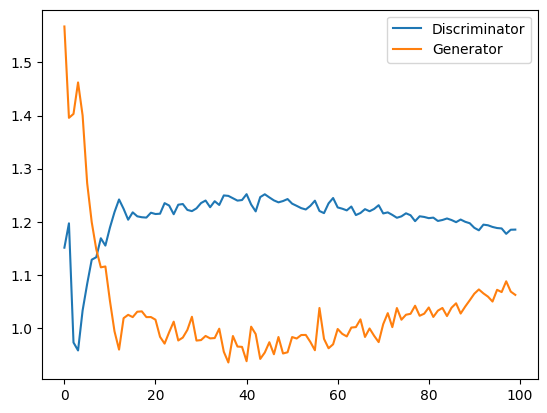

In [13]:
plt.plot(d_losess, label="Discriminator")
plt.plot(g_losses, label="Generator")
plt.legend()
plt.show()

As can be seen from the plot above, ...

#### Image generation improvements

To show that the generator is improving as epoch goes by, we show the images that it generates from different epochs.

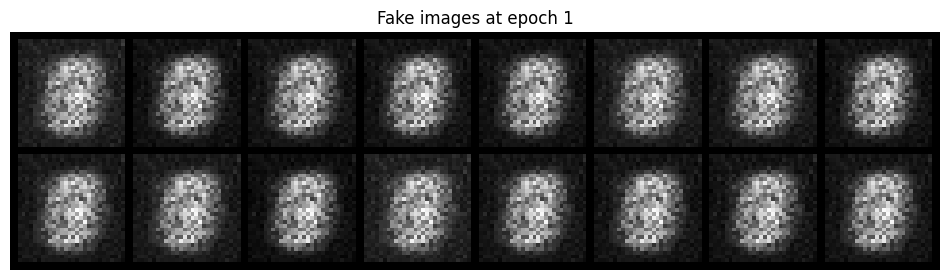

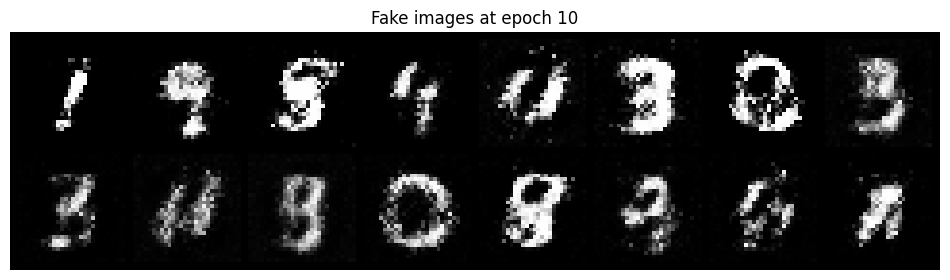

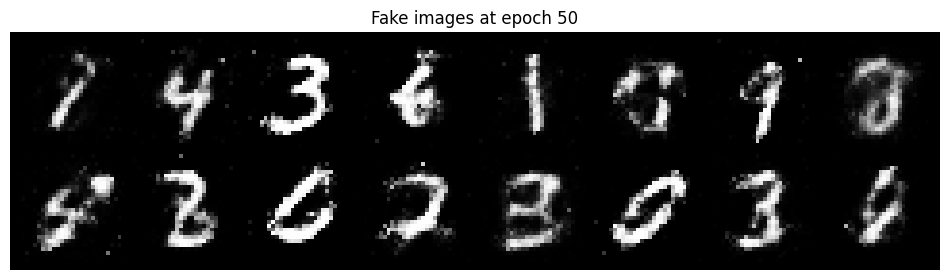

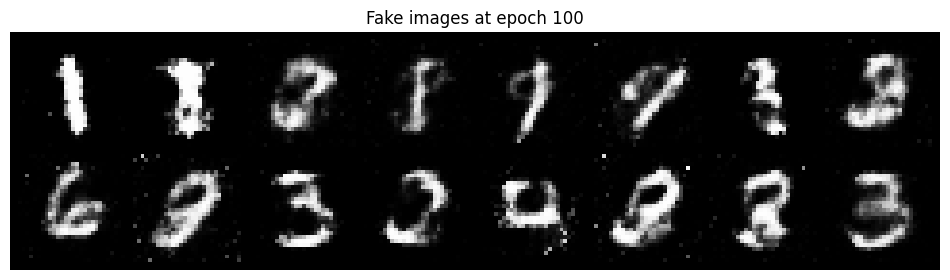

In [16]:
def show_generated_images(epoch: int):
    with open(FAKE_IMAGES_FILE, "rb") as f:
        saved_data: Tensor = pkl.load(f)

    epoch_data = saved_data[epoch - 1]

    batch_size, channel, height, width = len(epoch_data), 1, 28, 28
    image_batch = epoch_data.view(batch_size, channel, height, width)
    display_images(images=image_batch, title=f"Fake images at epoch {epoch}", figsize=(12, 4))


for epoch in [1, 10, 50, 100]:
    show_generated_images(epoch=epoch)